In [1]:
import os
import numpy as np
import pandas as pds
from random import shuffle
from collections import defaultdict

import rdkit
from rdkit.Chem import Draw
from rdkit.Chem.rdmolfiles import MolToSmiles
from rdkit.Chem.Draw import rdMolDraw2D, MolsToGridImage
from rdkit.Chem import AllChem, MolFromSmiles, DetectChemistryProblems

In [2]:
from libTMC.remove_ring_digits import *
from libTMC.valence_correction import *
from libTMC.molecular_properties import *

### Removing ring digits for unparsable TMC strings with unclosed rings
In this notebook, we demonstrate our removal algorithm and our workflow to retrieve unparsable TMC strings with unclosed rings.  
&emsp; In **section 1**, we focus on applying our text-based algorithm to remove redundant ring digits which have odd number of occurrence. We then visualize several molecule variations and calculate their molecular properties, especially these related to ring structures. The visualizations and the property results will help understanding the variance of many output molecules from removal algorithm. It also verifies that the molecular properties of the retrieved molecules are meaningful and representative, though we are randomly picking one molecule from the many results.  
  
&emsp; In **section 2**, we present our full workflow to retrieve unparsable TMC-SMILES strings, which are usually coupled with other issues, including extra dative bonds and improper valences. The workflow embeds several algorithms to remove redundant ring digits, identify & correct extra dative bonds, and fix improper valences to retrieve as many unparsable strings as possible and harvest their molecular properties. It also applies these algorithms in a specific order to minimize the operation steps.  
  
&emsp; In **section 3**, we briefly demonstrate how to fix the atoms having valence errors. The main challenge is to fix the charged atoms with valence errors.

#### Section 1: **removing extra digits for unclosed rings**
Example TMC-SMILES with unclosed rings:  
- double-digit rings:  
  Cc1ccc(-c2ccc3ccc4ccc(-c5ccc(C)cc5)n5->[Fe+2]67(<-n8cccc9ccc%10ccc(-n%11c(C)cc(C)cc%11n->6c%10c98)n->7c%10c98)(<-n2c3c45)<-O2CCCC2)cc1  
  COc1ccc2c3c(ccc4N5C=CN6Cc7cccc8N9C=CN(Cc%10ccc%11ccc%12c%11n(->[Fe+2]<-7%10%10%11)cc1c%10c%11ccc%12c%11n(C6)cc1[N-]->%10)cc8c7[N-]9)ccc2c1  
    
- single-digit rings only:  
  COc1ccccc1NC1CN23Cc4ccccn4->[Cu+2]<-24(<-[Cl-])(<-[O-]C=1c1ccccc1O3)<-n1ccccc1C2(O)c1ccccc1O3  
  CN(C)[C-](C=Cc1ccccc1)->[Zn+2]1234<-O5CCO->1Cc1ccccc1O->2C1CCCC1C(C1CCCC1O->3)C1CCCC[O-]->4  
  
The removal algorithm implemented here:
- **Step 1**: identify and collect all digits and their indices in strings. All digits and double-digits (after '%') may be ring identities
- **Step 2**: remove the indices that are not distinct ring identities, including,  
  - *a.*: digits that are double-counted, e.g., '1' in '%12'
  - *b.*: digits which are hydrogen counts, e.g., '[CH2-]' (after 'H')
  - *c.*: digits which are charges, e.g., '[Co+2]' and '[C-2]' (after '+' or '-')
- **Step 3**: exclude exceptions in *2.b* and *2.c*, including,  
  - *a.*: exception cases like digits in '[nH]1', in which the `1` is still a ring identity, for *2.b*
  - *b.*: exceptions like digits in '[BH+]1'. They still represent rings and are exceptions for *2.c*
  - *c.*: exceptions like digits after '<-', '->', and connection bond '-c1', for *2.c*
- **Step 4**: randomly pick one to remove if the digit has an odd number of occurrence. Summarize all possible picks, up to 10,000 samples with each having a slightly different structure (e.g., C1CCCCCC1, CCCC1CCC1, and C1CCC1CCC from 'C1CCC1CCC1')
- **Step 5**: visualizing and calculating molecular properties

###### **Examples 1**: unparsable string with single-digit rings only  
COc1ccccc1NC1CN23Cc4ccccn4->[Cu+2]<-24(<-[Cl-])(<-[O-]C=1c1ccccc1O3)<-n1ccccc1C2(O)c1ccccc1O3:  

In [3]:
## The original SMILES string has unclosed rings
## Single-digit string example:
raw = 'COc1ccccc1NC1CN23Cc4ccccn4->[Cu+2]<-24(<-[Cl-])(<-[O-]C=1c1ccccc1O3)<-n1ccccc1C2(O)c1ccccc1O3'
mol = MolFromSmiles(raw)

[16:32:11] SMILES Parse Error: unclosed ring for input: 'COc1ccccc1NC1CN23Cc4ccccn4->[Cu+2]<-24(<-[Cl-])(<-[O-]C=1c1ccccc1O3)<-n1ccccc1C2(O)c1ccccc1O3'


In [4]:
"""
    Show indices of all existing digits
"""
## Single-digit string:
all_digits = locate_digits(raw)
print('All single digits in the string')
for k, v in all_digits.items():
    print(k, ':', v)

All single digits in the string
1 : [3, 9, 12, 56, 58, 64, 71, 77, 84, 90]
2 : [15, 32, 36, 79]
3 : [16, 66, 92]
4 : [19, 25, 37]



   - The '2' at index 32 is a positive charge that should be excluded, in '[Cu+2]'
   - The '2' at index 36 is still a ring identity though it's after '-', in '<-24'
   - Also, the '4' at index 37 is a ring identity in '<-24'

In [5]:
"""
    Screen the digits which are not ring identities.
    Exceptions should be considered in the screening process.
"""
screened_digits = screen_digits(raw, all_digits)
print('The screened digits in the string')
for k, v in screened_digits.items():
    print(k, ':', v)

The screened digits in the string
1 : [3, 9, 12, 56, 58, 64, 71, 77, 84, 90]
2 : [15, 36, 79]
3 : [16, 66, 92]
4 : [19, 25, 37]


The '2' at index 32 should be the only screened digit which is a charge.  
> additional '2', '3', and '4' should be removed.

In [6]:
"""
    Enumerate all possible combinations
    (without considering other chemical issues, e.g., aromatic atoms outside the rings and etc.)
"""
results = fix_simple_smi(raw)
print('Possible output strings:')
for ir, res in enumerate(results):
    print(ir+1, '.', res)

Possible output strings:
1 . COc1ccccc1NC1CNCcccccn4->[Cu+2]<-24(<-[Cl-])(<-[O-]C=1c1ccccc1O3)<-n1ccccc1C2(O)c1ccccc1O3
2 . COc1ccccc1NC1CNCc4ccccn->[Cu+2]<-24(<-[Cl-])(<-[O-]C=1c1ccccc1O3)<-n1ccccc1C2(O)c1ccccc1O3
3 . COc1ccccc1NC1CNCc4ccccn4->[Cu+2]<-2(<-[Cl-])(<-[O-]C=1c1ccccc1O3)<-n1ccccc1C2(O)c1ccccc1O3
4 . COc1ccccc1NC1CN3Ccccccn4->[Cu+2]<-24(<-[Cl-])(<-[O-]C=1c1ccccc1O)<-n1ccccc1C2(O)c1ccccc1O3
5 . COc1ccccc1NC1CN3Cc4ccccn->[Cu+2]<-24(<-[Cl-])(<-[O-]C=1c1ccccc1O)<-n1ccccc1C2(O)c1ccccc1O3
6 . COc1ccccc1NC1CN3Cc4ccccn4->[Cu+2]<-2(<-[Cl-])(<-[O-]C=1c1ccccc1O)<-n1ccccc1C2(O)c1ccccc1O3
7 . COc1ccccc1NC1CN3Ccccccn4->[Cu+2]<-24(<-[Cl-])(<-[O-]C=1c1ccccc1O3)<-n1ccccc1C2(O)c1ccccc1O
8 . COc1ccccc1NC1CN3Cc4ccccn->[Cu+2]<-24(<-[Cl-])(<-[O-]C=1c1ccccc1O3)<-n1ccccc1C2(O)c1ccccc1O
9 . COc1ccccc1NC1CN3Cc4ccccn4->[Cu+2]<-2(<-[Cl-])(<-[O-]C=1c1ccccc1O3)<-n1ccccc1C2(O)c1ccccc1O
10 . COc1ccccc1NC1CN2Ccccccn4->[Cu+2]<-4(<-[Cl-])(<-[O-]C=1c1ccccc1O3)<-n1ccccc1C2(O)c1ccccc1O3
11 . COc1ccccc1NC1CN2Cc4

In [7]:
"""
    Test if output strings are valid after removal
"""
tests = [MolFromSmiles(n) for n in results]
val_mols = [n for n in tests if n!=None]
print('Total number of valid molecules:', len(val_mols))

Total number of valid molecules: 6


[16:32:12] SMILES Parse Error: ring closure 4 duplicates bond between atom 18 and atom 19 for input: 'COc1ccccc1NC1CNCcccccn4->[Cu+2]<-24(<-[Cl-])(<-[O-]C=1c1ccccc1O3)<-n1ccccc1C2(O)c1ccccc1O3'
[16:32:12] non-ring atom 13 marked aromatic
[16:32:12] SMILES Parse Error: ring closure 4 duplicates bond between atom 18 and atom 19 for input: 'COc1ccccc1NC1CN3Ccccccn4->[Cu+2]<-24(<-[Cl-])(<-[O-]C=1c1ccccc1O)<-n1ccccc1C2(O)c1ccccc1O3'
[16:32:12] non-ring atom 13 marked aromatic
[16:32:12] SMILES Parse Error: ring closure 4 duplicates bond between atom 18 and atom 19 for input: 'COc1ccccc1NC1CN3Ccccccn4->[Cu+2]<-24(<-[Cl-])(<-[O-]C=1c1ccccc1O3)<-n1ccccc1C2(O)c1ccccc1O'
[16:32:12] non-ring atom 13 marked aromatic
[16:32:12] SMILES Parse Error: ring closure 4 duplicates bond between atom 18 and atom 19 for input: 'COc1ccccc1NC1CN2Ccccccn4->[Cu+2]<-4(<-[Cl-])(<-[O-]C=1c1ccccc1O3)<-n1ccccc1C2(O)c1ccccc1O3'
[16:32:12] non-ring atom 13 marked aromatic
[16:32:12] SMILES Parse Error: syntax error whil

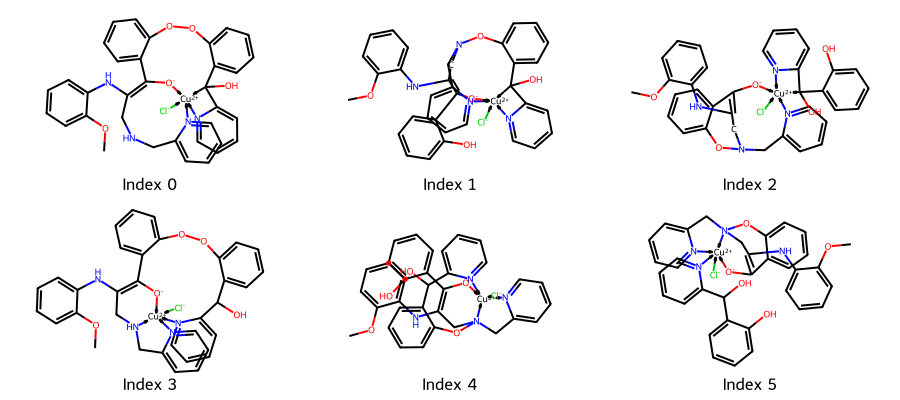

In [8]:
"""
    Visualize the retrieved molecules (with 'previously' unclosed rings)
"""
MolsToGridImage(val_mols, molsPerRow=int(len(val_mols)/2), subImgSize=(300,200), legends=[f'Index {n}' for n in range(len(val_mols))])

In [11]:
"""
    Compute the molecular properties of the retrieved molecules
"""
from rdkit.Chem.rdmolops import GetSSSR
from libTMC.molecular_properties import *

In [12]:
outdict = defaultdict(list)
for imol, mol in enumerate(val_mols):
    ## calculate TMC rings
    sssr = GetSSSR(mol, includeDativeBonds=True)
    t_ri = mol.GetRingInfo()
    t_ring_sizes = get_all_ring_sizes(mol)
    t_fused_indices = get_fused_ring_idx(mol)
    
    t_num_r = t_ri.NumRings()
    t_num_fused = len(t_fused_indices)
    t_macro = len([n for n in t_ring_sizes if n>7])
    
    ## calculate ligands rings
    sssr = GetSSSR(mol, includeDativeBonds=False)
    l_ri = mol.GetRingInfo()
    l_ring_sizes = get_all_ring_sizes(mol)
    l_fused_indices = get_fused_ring_idx(mol)
    
    l_num_r = l_ri.NumRings()
    l_num_fused = len(l_fused_indices)
    l_macro = len([n for n in l_ring_sizes if n>7])
    outdict['Index'].append(imol)
    outdict[r'$N_{\mathrm{rings}}$'].append(t_num_r)
    outdict[r'$N_{\mathrm{fused\ rings}}$'].append(t_num_fused)
    outdict[r'$N^{\mathrm{ligand}}_{\mathrm{rings}}$'].append(l_num_r)
    outdict[r'$N^{\mathrm{ligand}}_{\mathrm{fused\ rings}}$'].append(l_num_fused)
    ## the change of rings / fused rings between TMCs and ligands
    outdict[r'$\Delta N_{\mathrm{rings}}$'].append(t_num_r-l_num_r)
    outdict[r'$\Delta N_{\mathrm{fused\ rings}}$'].append(t_num_fused-l_num_fused)
    
    outdict[r'$N_{\mathrm{macrocycles}}^{\mathrm{TMC}}$'].append(t_macro)
    outdict[r'$N_{\mathrm{macrocycles}}^{\mathrm{ligand}}$'].append(l_macro)

In [13]:
outdf = pds.DataFrame(outdict)
outdf.head(20)

,Index,$N_{\mathrm{rings}}$,$N_{\mathrm{fused\ rings}}$,$N^{\mathrm{ligand}}_{\mathrm{rings}}$,$N^{\mathrm{ligand}}_{\mathrm{fused\ rings}}$,$\Delta N_{\mathrm{rings}}$,$\Delta N_{\mathrm{fused\ rings}}$,$N_{\mathrm{macrocycles}}^{\mathrm{TMC}}$,$N_{\mathrm{macrocycles}}^{\mathrm{ligand}}$
0,0,8,7,5,0,3,7,2,0
1,1,8,6,5,0,3,6,2,0
2,2,8,6,6,2,2,4,1,0
3,3,8,7,5,0,3,7,1,0
4,4,8,6,5,0,3,6,1,0
5,5,8,5,6,2,2,3,0,0


The structures and the molecular properties vary for the many results from ring-removal algorithm, but the variances are not significant and the properties are representative.

###### **Examples 2**: double-digit rings in unparsable strings  
Cc1ccc(-c2ccc3ccc4ccc(-c5ccc(C)cc5)n5->[Fe+2]67(<-n8cccc9ccc%10ccc(-n%11c(C)cc(C)cc%11n->6c%10c98)n->7c%10c98)(<-n2c3c45)<-O2CCCC2)cc1:  

In [14]:
## Double-digit string example:
raw = 'Cc1ccc(-c2ccc3ccc4ccc(-c5ccc(C)cc5)n5->[Fe+2]67(<-n8cccc9ccc%10ccc(-n%11c(C)cc(C)cc%11n->6c%10c98)n->7c%10c98)(<-n2c3c45)<-O2CCCC2)cc1'
mol = MolFromSmiles(raw)

[16:43:22] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2ccc3ccc4ccc(-c5ccc(C)cc5)n5->[Fe+2]67(<-n8cccc9ccc%10ccc(-n%11c(C)cc(C)cc%11n->6c%10c98)n->7c%10c98)(<-n2c3c45)<-O2CCCC2)cc1'


In [15]:
all_digits = locate_digits(raw)
double_digits = locate_double_digit_rings(raw)
print('All single digits in the string')
for k, v in all_digits.items():
    print(k, ':', v)
print('All double digits in the string')
for k, v in double_digits.items():
    print(k, ':', v)

All single digits in the string
1 : [2, 61, 70, 71, 84, 85, 92, 104, 133]
2 : [9, 43, 114, 124, 129]
3 : [13, 116]
4 : [17, 118]
5 : [24, 33, 36, 119]
6 : [45, 89]
7 : [46, 101]
8 : [51, 96, 108]
9 : [56, 95, 107]
All double digits in the string
10 : [60, 91, 103]
11 : [69, 83]



   - The '1' at index 61, 92, 104 are double counted from double-digit ring '%10'. Similarly, the '1' at index 70, 71, 84, and 85 are double counted from the ring '%11'
   - The '2' at index 43 is a positive charge in '[Fe+2]'
   - The '2' at index 9, 114, and 124 are ring identities even though they are after '-', in '-c2', '-n2', and '-O2' respectively
   - The '6', '7', and '8' at index 89, 101, and 51 are ring identities in '->6', '->7', and '-n8'

In [16]:
scr1_digits = screen_digits(raw, all_digits)
## exclude double-counted indices from double-digit rings
scr2_digits = screen_double_digits(raw, scr1_digits, double_digits)

print('The screened digits in the string (single-digit only)')
## Screening double-digits is unnecessary because they are distinct after '%'
for k, v in scr2_digits.items():
    print(k, ':', v)

The screened digits in the string (single-digit only)
1 : [2, 133]
2 : [9, 114, 124, 129]
3 : [13, 116]
4 : [17, 118]
5 : [24, 33, 36, 119]
6 : [45, 89]
7 : [46, 101]
8 : [51, 96, 108]
9 : [56, 95, 107]


Most '1' are double-counted digits from '%10' and '%11' so they are screened accordingly.  
The '2' at index 43 is screened because it's a positive charge.  
> Additional '8', '9', and '%10' should be removed

In [17]:
results = fix_complex_smi(raw)
print('Possible output strings:')
for ir, res in enumerate(results):
    print(ir+1, '.', res)

Possible output strings:
1 . Cc1ccc(-c2ccc3ccc4ccc(-c5ccc(C)cc5)n5->[Fe+2]67(<-ncccccccccc(-n%11c(C)cc(C)cc%11n->6c%10c98)n->7c%10c98)(<-n2c3c45)<-O2CCCC2)cc1
2 . Cc1ccc(-c2ccc3ccc4ccc(-c5ccc(C)cc5)n5->[Fe+2]67(<-ncccc9cccccc(-n%11c(C)cc(C)cc%11n->6c%10c8)n->7c%10c98)(<-n2c3c45)<-O2CCCC2)cc1
3 . Cc1ccc(-c2ccc3ccc4ccc(-c5ccc(C)cc5)n5->[Fe+2]67(<-ncccc9cccccc(-n%11c(C)cc(C)cc%11n->6c%10c98)n->7c%10c8)(<-n2c3c45)<-O2CCCC2)cc1
4 . Cc1ccc(-c2ccc3ccc4ccc(-c5ccc(C)cc5)n5->[Fe+2]67(<-n8cccccccccc(-n%11c(C)cc(C)cc%11n->6c%10c9)n->7c%10c98)(<-n2c3c45)<-O2CCCC2)cc1
5 . Cc1ccc(-c2ccc3ccc4ccc(-c5ccc(C)cc5)n5->[Fe+2]67(<-n8cccc9cccccc(-n%11c(C)cc(C)cc%11n->6c%10c)n->7c%10c98)(<-n2c3c45)<-O2CCCC2)cc1
6 . Cc1ccc(-c2ccc3ccc4ccc(-c5ccc(C)cc5)n5->[Fe+2]67(<-n8cccc9cccccc(-n%11c(C)cc(C)cc%11n->6c%10c9)n->7c%10c8)(<-n2c3c45)<-O2CCCC2)cc1
7 . Cc1ccc(-c2ccc3ccc4ccc(-c5ccc(C)cc5)n5->[Fe+2]67(<-n8cccccccccc(-n%11c(C)cc(C)cc%11n->6c%10c98)n->7c%10c9)(<-n2c3c45)<-O2CCCC2)cc1
8 . Cc1ccc(-c2ccc3ccc4ccc(-c5ccc(C)cc

In [18]:
tests = [MolFromSmiles(n) for n in results]
val_mols = [n for n in tests if n!=None]
print('Total number of valid molecules:', len(val_mols))

Total number of valid molecules: 12


[16:43:31] SMILES Parse Error: ring closure 9 duplicates bond between atom 45 and atom 48 for input: 'Cc1ccc(-c2ccc3ccc4ccc(-c5ccc(C)cc5)n5->[Fe+2]67(<-ncccccccccc(-n%11c(C)cc(C)cc%11n->6c%10c98)n->7c%10c98)(<-n2c3c45)<-O2CCCC2)cc1'
[16:43:31] non-ring atom 24 marked aromatic
[16:43:31] non-ring atom 24 marked aromatic
[16:43:31] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32 33 34 36 38 39 41 42 43 44 46 47 48
[16:43:32] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32 33 34 36 38 39 41 42 43 44 45 46 47
[16:43:32] SMILES Parse Error: ring closure 9 duplicates bond between atom 45 and atom 48 for input: 'Cc1ccc(-c2ccc3ccc4ccc(-c5ccc(C)cc5)n5->[Fe+2]67(<-nccccccc%10ccc(-n%11c(C)cc(C)cc%11n->6cc98)n->7c%10c98)(<-n2c3c45)<-O2CCCC2)cc1'
[16:43:32] non-ring atom 24 marked aromatic
[16:43:32] non-ring atom 24 marked aromatic
[16:43:32] Can't kekulize mol.  Unkekulized atoms: 36 38 39 41 42
[16:43:32] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 2

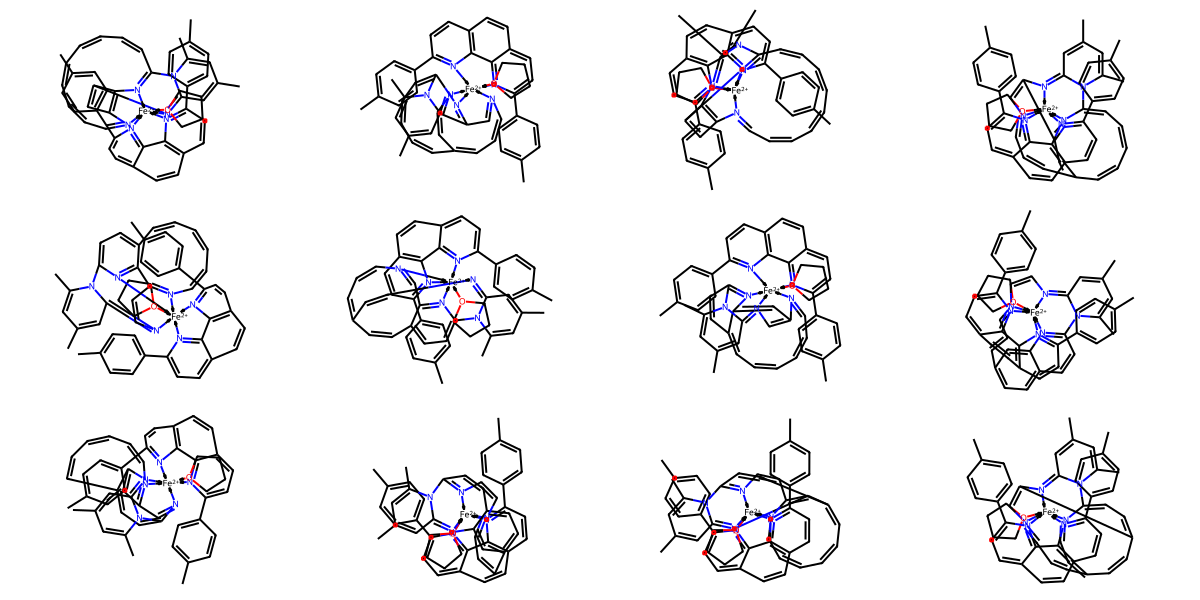

In [19]:
MolsToGridImage(val_mols, molsPerRow=int(len(val_mols)/3), subImgSize=(300,200))

In [20]:
outdict = defaultdict(list)
for imol, mol in enumerate(val_mols):
    ## calculate TMC rings
    sssr = GetSSSR(mol, includeDativeBonds=True)
    t_ri = mol.GetRingInfo()
    t_ring_sizes = get_all_ring_sizes(mol)
    t_fused_indices = get_fused_ring_idx(mol)
    
    t_num_r = t_ri.NumRings()
    t_num_fused = len(t_fused_indices)
    t_macro = len([n for n in t_ring_sizes if n>7])
    
    ## calculate ligands rings
    sssr = GetSSSR(mol, includeDativeBonds=False)
    l_ri = mol.GetRingInfo()
    l_ring_sizes = get_all_ring_sizes(mol)
    l_fused_indices = get_fused_ring_idx(mol)
    
    l_num_r = l_ri.NumRings()
    l_num_fused = len(l_fused_indices)
    l_macro = len([n for n in l_ring_sizes if n>7])
    outdict['Index'].append(imol)
    outdict[r'$N_{\mathrm{rings}}$'].append(t_num_r)
    outdict[r'$N_{\mathrm{fused\ rings}}$'].append(t_num_fused)
    outdict[r'$N^{\mathrm{ligand}}_{\mathrm{rings}}$'].append(l_num_r)
    outdict[r'$N^{\mathrm{ligand}}_{\mathrm{fused\ rings}}$'].append(l_num_fused)
    ## the change of rings / fused rings between TMCs and ligands
    outdict[r'$\Delta N_{\mathrm{rings}}$'].append(t_num_r-l_num_r)
    outdict[r'$\Delta N_{\mathrm{fused\ rings}}$'].append(t_num_fused-l_num_fused)
    
    outdict[r'$N_{\mathrm{macrocycles}}^{\mathrm{TMC}}$'].append(t_macro)
    outdict[r'$N_{\mathrm{macrocycles}}^{\mathrm{ligand}}$'].append(l_macro)

In [21]:
outdf = pds.DataFrame(outdict)
outdf.head(20)

,Index,$N_{\mathrm{rings}}$,$N_{\mathrm{fused\ rings}}$,$N^{\mathrm{ligand}}_{\mathrm{rings}}$,$N^{\mathrm{ligand}}_{\mathrm{fused\ rings}}$,$\Delta N_{\mathrm{rings}}$,$\Delta N_{\mathrm{fused\ rings}}$,$N_{\mathrm{macrocycles}}^{\mathrm{TMC}}$,$N_{\mathrm{macrocycles}}^{\mathrm{ligand}}$
0,0,13,10,10,7,3,3,1,1
1,1,13,10,10,7,3,3,2,2
2,2,13,10,10,7,3,3,1,1
3,3,13,10,10,7,3,3,2,2
4,4,13,10,10,7,3,3,1,2
5,5,13,10,10,7,3,3,2,2
6,6,13,10,10,7,3,3,1,2
7,7,13,10,10,7,3,3,1,1
8,8,13,10,10,7,3,3,2,3
9,9,13,10,10,7,3,3,2,2


#### Section 2: full workflow to retrieve unparsable strings with unclosed rings
Here we demonstrate a complete workflow to retrieve a set of TMC-SMILES strings with unclosed rings. Multiple issues need to be addressed in the workflow because unparsable strings are usually coupled with other errors, including additional dative bonds not connecting with metal atoms and valence errors (after removing rings). The example dataset `unparsable_examples.csv` has four columns:  
&emsp; &emsp; (1). **LLM_SMI**: TMC-SMILES with unclosed rings  
&emsp; &emsp; (2). **Valence**: if the fixed strings (after removing extra ring digits) have valence errors  
&emsp; &emsp; (3). **Dative**: if the strings have extra dative bonds. It's a common issue which needs to be fixed, but is unrelated to ring issues  
&emsp; &emsp; (4). **TotalNum**: total number of valid strings after removing ring digits  
  
The workflow has three steps:
- **Step 1**: Take unparsable TMC SMILES strings and remove redundant ring digits to generate RDKit-parsable `mol` object for further operations. The RDKit `mol`s are not sanitized because many of them have dative bond errors and valence errors. Each unparsable string may have multiple attempt strings too. After obtaining parsable `mol`s, we exclude the molecules without TM atoms and fix extra dative bonds by replacing them with single bonds. The output dictionary, `vd_dict`, in this step includes lists of parsable molecules which,
  - don't have other syntax errors or duplicated bonds on ring closure
  - have one TM center
  - no extra dative bonds, i.e., all dative bonds are atom connections between metals and organic ligands
- **Step 2**: since valence error is the only chemical issue we can fix here, we screen the molecules that have multiple other chemical issues, e.g., aromatic atoms not in a ring. We use the `DetectChemistryProblems` in RDKit to find all chemistry errors in molecules, in which the valence errors can be identified by '**Explicit valence**' in problem messages. Multiple valence errors are allowed in a parsable molecule while no other errors should be allowed. The output dictionary in this step, `valdict`, includes lists of parsable (without sanitization) molecules which only have valence errors.
- **Step 3**: we fix valence errors in this step. There are two remaining issues after fixing the valence errors by changing the atom types:
  1. since there can be multiple valence errors in a molecule, changing all these atoms may lead to other new errors such as kekulization errors.
  2. Since the kekulization algorithm in RDKit is incompatible with its canonicalization aglorithm, as described [here](https://www.rdkit.org/docs/GettingStartedInPython.html#writing-molecules) and [here](https://github.com/rdkit/rdkit/issues/5784), we need to try sanitizing the canonical SMILES of final molecules even though they are parsable and don't have any chemical issues. Canonical SMILES that have kekulization issues will be excluded.  
  
  Thus, we need to check the sanitizability of all final canonical TMC-SMILES strings and only take valid ones in the output dictionary `outdict`. The `repdict` is a dictionary of retrieved TMCs with one representative for each unparsable string. 

In [3]:
unpardf = pds.read_csv('./unparsable_examples.csv').drop(['Unnamed: 0'], axis=1)
unpardf.head(10)

,LLM_SMI,Valence,Dative,TotalNum
0,CCC1(CC)CC(C)(C)N(CCCC([N+](C)(C)C)C2(C)[O-]->...,True,True,9
1,N#CC1C2(Cc3cccc4Oc5cccc6C=[SH]C77OCC4c4c(O)c5c...,True,True,15
2,C1=CC2=C3C=C(C4=N5->[Ni+2]67(<-N(=C8C=C(C9=N->...,True,True,24
3,CC1(C)O[O-]->[Cu+2]2(<-[O-]CCN->2(C)C)(<-N2=C(...,True,True,4
4,CCO[Si](C)(C)[C-]12->[Cr+3]34(<-[C-]#[O+])(<-[...,True,True,6
5,O=C1CN2CC(=O)[O-]->[Co+2]<-234(<-[O-]1)<-n1ccc...,True,True,5
6,CC1(C)C2CCC3N2->[Cu+2]2(<-N3=C1CCC3C(C)(C)C1CC...,True,True,100
7,CP1(C)CCP(C)(C)->[Ta+3]<-12(<-[C-]#[O+])(<-[N-...,True,True,8
8,CC(C)C1COC2C=C3c4ccccc4C4C=C5OCC(C(C)C)[N-]5->...,True,True,9
9,C=C([N-]1c2ccccc2C(C)N12Cc1ccccc1)->[Fe+2]<-12...,True,True,12


###### **Section 2.1: generate parsable RDKit molecules without dative bond errors**
1. We first use `fix_simple_smi` (for strings having less than 10 rings) or `fix_complex_smi` (for strings with '%' and having more than 10 rings) to remove redundant ring digits. These two functions will return a list of attempt strings, which may create parsable RDKit molecules. Common errors are duplicated bonds in ring closure and other syntax errors (the attempt strings fail to follow SMILES notation principles).
2. Then, we obtain RDKit `mol` objects from fixed strings and exclude the molecules without TM atoms. The obtained `mol`s are not sanitized because many errors need to be fixed later and we only need executable RDKit objects at this stage.
3. Finally, we fix the extra dative bonds in these molecules. All dative bonds in molecules that are not connected with TM atoms will be replaced by single bonds.  
  
**Note**: an interesting observation is that, by removing different ring digits, the connecting atoms of dative bonds may change and dative bonds may occasionally connect with non-TM atoms on ring closure if the original closure digits are removed. An example at the end of this section will demonstrate such effect.  
  
The `vd_dict` is the main output and it contains RDKit parsable `mol`s. The `bonddict` is a subset of `vd_dict` and it lists the TMCs which have molecule variations both with and without dative bond errors.

In [ ]:
vd_dict = defaultdict(list)
bonddict = defaultdict(list)
for idx, (smi, l) in enumerate(zip(unpardf['LLM_SMI'], unpardf['TotalNum'])):
    """
        - Obtain strings after removing ring digits
    """
    if '%' in smi:
        att_smis = fix_complex_smi(smi) ## these are strings only
    else:
        att_smis = fix_simple_smi(smi)
    vmols = []
    vmdat = []
    vmsmi = []
    for fsmi in att_smis:
        
        ## Exclude the strings which cannot be parsed 
        ## (without sanitization).
        ## Common errors are duplicated ring closure 
        ## bonds and other syntax errors.
        try:
            tmol = MolFromSmiles(fsmi, sanitize=False)
        except:
            continue
        if tmol==None:
            continue

        """
            - Exclude the strings not having TM atoms or having
            more than one TM atom (the generated TMCs should
            be mononuclear)
        """
        tm_idx_list, tm_atomId_list = find_all_tms(tmol)
        if len(tm_idx_list)!=1:
            print(idx, 'TMC more than one TM atom!', len(tm_idx_list))
            continue

        """
            - Fix dative bond errors
        """
        dmol, err_dative = fix_dative_bonds(tmol)
        datv = len(err_dative)>0
        if datv:
            vmols.append(dmol)
            vmdat.append(True)
        else:
            vmols.append(tmol)
            vmdat.append(False)
        vmsmi.append(fsmi)
    
    vd_dict['ID'].append(idx)
    vd_dict['LLM_SMI'].append(smi)
    vd_dict['NumAttempts'].append(len(vmols))
    vd_dict['Attempt_Strings'].append(','.join([MolToSmiles(n) for n in vmols]))
    vd_dict['Dative_Strings'].append(','.join([str(n) for n in vmdat]))
    vd_dict['Mol_list'].append(vmols)
    vd_dict['Dative_list'].append(vmdat)
    if len(vmdat)!=sum(vmdat):
        bonddict['ID'].append(idx)
        bonddict['LLM_SMI'].append(smi)
        bonddict['SMI_Length'].append(len(smi))
        bonddict['NumAttempts'].append(len(vmols))
        bonddict['Attempt_Strings'].append(','.join([MolToSmiles(n) for n in vmols]))
        bonddict['Raw_Strings'].append(','.join(vmsmi))
        bonddict['Dative_Strings'].append(','.join([str(n) for n in vmdat]))

In [5]:
vddf = pds.DataFrame({k: [n for n in v] for k, v in vd_dict.items() if not 'list' in k})
vddf.head(10)

,ID,LLM_SMI,NumAttempts,Attempt_Strings,Dative_Strings
0,0,CCC1(CC)CC(C)(C)N(CCCC([N+](C)(C)C)C2(C)[O-]->...,9,CCC1(CC)CC(C)(C)N2CCCC([N+](C)(C)C)C(C)[O-]->[...,"True,True,True,True,True,True,True,True,True"
1,1,N#CC1C2(Cc3cccc4Oc5cccc6C=[SH]C77OCC4c4c(O)c5c...,150,N#CC1[O-]->[Cr+3]2345<-O=C6C7=C([O-]OCCN->2(C7...,"True,True,True,True,True,True,True,True,True,T..."
2,2,C1=CC2=C3C=C(C4=N5->[Ni+2]67(<-N(=C8C=C(C9=N->...,25,C1=CC2=CN3->[Ni+2]45(<-N=CC6=CC2=C2C=Cc7ccccc7...,"True,True,True,True,True,True,True,True,True,T..."
3,3,CC1(C)O[O-]->[Cu+2]2(<-[O-]CCN->2(C)C)(<-N2=C(...,4,CC1(C)COC2=CC(=N3->[Cu+2]4(<-[O-]CCN3(C)C)<-[O...,"True,True,True,True"
4,4,CCO[Si](C)(C)[C-]12->[Cr+3]34(<-[C-]#[O+])(<-[...,14,CCO[Si](C)(C)[C-]1->[Cr+3]2(<-[C-]#[O+])(<-[C-...,"True,True,True,True,True,True,True,True,True,T..."
5,5,O=C1CN2CC(=O)[O-]->[Co+2]<-234(<-[O-]1)<-n1ccc...,5,O=C1CNCC(=O)[O-]->[Co+2]234(<-[O-]1)<-c1cccn->...,"True,True,True,True,True"
6,6,CC1(C)C2CCC3N2->[Cu+2]2(<-N3=C1CCC3C(C)(C)C1CC...,100,CC(C)C1CCCN->[Cu+2]1(<-[O-][N+](=O)[O-])<-N1=C...,"True,True,True,True,True,True,True,True,True,T..."
7,7,CP1(C)CCP(C)(C)->[Ta+3]<-12(<-[C-]#[O+])(<-[N-...,8,CN1CCCCCC2CCCCCC3->[Ta+3]4(<-[C-]#[O+])(<-P(C)...,"True,True,True,True,True,True,True,True"
8,8,CC(C)C1COC2C=C3c4ccccc4C4C=C5OCC(C(C)C)[N-]5->...,9,CC(C)C1COCC=Cc2ccccc2C2=N3->[Ni+2]4(<-N1=C1=N-...,"True,True,True,True,True,True,True,True,True"
9,9,C=C([N-]1c2ccccc2C(C)N12Cc1ccccc1)->[Fe+2]<-12...,68,C=C1->[Fe+2]23(<-cccccc4CN45c(ccccc[N-]1)C5C)(...,"False,False,False,True,False,False,False,True,..."


###### **Subset of TMCs with and without dative bond errors**
Here we present some short examples (less than 110 characters) with and without dative bond errors after removing ring digits.

In [5]:
bonddf = pds.DataFrame(bonddict)
bonddf.head()

,ID,LLM_SMI,SMI_Length,NumAttempts,Attempt_Strings,Raw_Strings,Dative_Strings
0,1,N#CC1C2(Cc3cccc4Oc5cccc6C=[SH]C77OCC4c4c(O)c5c...,117,150,N#CC1[O-]->[Cr+3]2345<-O=C6C7=C([O-]OCCN->2(C7...,N#CC1C2(Cccccc4Occccc6C=[SH]C7OCCc4c(O)c5ccccc...,"True,True,True,True,True,True,True,True,True,T..."
1,9,C=C([N-]1c2ccccc2C(C)N12Cc1ccccc1)->[Fe+2]<-12...,145,68,C=C1->[Fe+2]23(<-cccccc4CN45c(ccccc[N-]1)C5C)(...,C=C([N-]cccccc2C(C)N12Cc1ccccc1)->[Fe+2]<-123(...,"False,False,False,True,False,False,False,True,..."
2,15,C=CCc1cc(C)cc2c1-c12P(C(c1ccccc1)(c1ccccc1)c1c...,133,33,C=CCc1cc(C)ccc-c12C=P(C(C)(C)C)(C(C)(C)C)[C-]1...,C=CCc1cc(C)ccc-c12P(C(c1ccccc1)(c1ccccc1)c1ccc...,"False,False,False,False,False,False,False,Fals..."
3,16,c1ccc(P2(NCc3cccc[n+]35->[IrH+2]456(<-[c-]34C2...,108,20,c1cccc[n+]2->[IrH+2]34<-[c-]5ccccc6ccc(n->3c65...,c1ccc(P2(NCccccc[n+]3->[IrH+2]5(<-[c-]34C2)<-n...,"True,False,True,True,True,False,True,True,True..."
4,26,CCCCCOP12([S-]->[Ni+2]1(<-[c-]3ccccc3)<-N(C)(C...,90,8,CCCCCO[PH]1([S-]->[Ni+2]2(<-[c-]3ccccc3)<-N(C)...,CCCCCOP2([S-]->[Ni+2]1(<-[c-]3ccccc3)<-N(C)(C)...,"False,True,True,True,True,True,True,True"


In [6]:
## Select these strings with less than 110 characters and more than 10 variations
subset = bonddf.loc[(bonddf['SMI_Length']<=110) & (bonddf['NumAttempts']>=10)]
subdict = subset.to_dict()
print('Total number of examples:', len(subset['ID']))
print('Example indices:', ', '.join([str(n) for n in subdict['ID'].keys()]))
subset.head()

Total number of examples: 6
Example indices: 3, 11, 15, 22, 28, 33


,ID,LLM_SMI,SMI_Length,NumAttempts,Attempt_Strings,Raw_Strings,Dative_Strings
3,16,c1ccc(P2(NCc3cccc[n+]35->[IrH+2]456(<-[c-]34C2...,108,20,c1cccc[n+]2->[IrH+2]34<-[c-]5ccccc6ccc(n->3c65...,c1ccc(P2(NCccccc[n+]3->[IrH+2]5(<-[c-]34C2)<-n...,"True,False,True,True,True,False,True,True,True..."
11,36,CC1=C2C=CC=C[N-]2->[Co+4]234(<-[N-]5C=CC=CC5=C...,105,25,CC=C1C=CC=C[N-]->[Co+4]123(<-N1CCCC1)<-N1=C(C)...,CC=C2C=CC=C[N-]->[Co+4]234(<-[N-]5C=CC=CC5=C(C...,"True,True,False,False,False,True,True,False,Fa..."
15,40,CC1=CC2=C->[Ir+]34(<-C=C(C)C=C->3C)(<-[c-]3ccc...,97,11,CC=CC1=C->[Ir+]2(<-P(C(C)C)(C(C)C)C(C)C)(<-C=C...,CC=CC2=C->[Ir+]3(<-C=C(C)C=C->3C)(<-[c-]3cccc4...,"True,False,True,True,False,True,True,False,Tru..."
22,47,CC1(C)C2CCC3C(C)(C)C4=N(->[Fe+2](<-[Cl-])(<-[C...,98,15,CC(C)C1CCCC(C)(C)C=N2->[Fe+2](<-[Cl-])(<-[Cl-]...,CC(C)C2CCCC(C)(C)C=N(->[Fe+2](<-[Cl-])(<-[Cl-]...,"False,False,False,False,False,False,False,Fals..."
28,53,Cc1ccc2[O-]->[Ni+2]3(<-[O-]c4ccc(C)cc4C=N->3Cc...,106,25,Cc1ccc2c(c1)C=N1->[Ni+2](<-[O-]cccc(C)cc3c(ccc...,Cc1ccc2[O-]->[Ni+2](<-[O-]cccc(C)cc4C=N->3Cc3c...,"True,True,True,True,True,True,True,True,True,T..."


In [7]:
expIdx = 3
att_strs = subdict['Attempt_Strings'][expIdx].split(',')
att_davs = subdict['Dative_Strings'][expIdx].split(',')

## Present a few examples
print(f'Original TMC-SMILES with unclosed rings:\n{subdict['LLM_SMI'][expIdx]}\n')
with_dative_errors = [sidx for sidx, datv in enumerate(att_davs) if datv=='True']
without_dative_errors = [sidx for sidx, datv in enumerate(att_davs) if datv=='False']
num_exp = min(len(with_dative_errors), len(without_dative_errors), 4) ## number of examples presented (<=4)
for w, indices in zip(['with', 'without'], [with_dative_errors, without_dative_errors]):
    print(f'Examples {w} dative errors:')
    for idx in indices[:num_exp]:
        print(att_strs[idx])
    print('')

Original TMC-SMILES with unclosed rings:
c1ccc(P2(NCc3cccc[n+]35->[IrH+2]456(<-[c-]34C2)<-n2c(CP->4(c4ccccc4)c4ccccc4)ccc3cccc[c-]->5c32)c2ccccc2)cc1

Examples with dative errors:
c1cccc[n+]2->[IrH+2]34<-[c-]5ccccc6ccc(n->3c65)C[PH](c3ccccc3)(c3ccccc3)[c-]->42C[PH](c2ccccc2)(c2ccccc2)NC1
c1cccc[n+]23->[IrH+2]4<-n5c(ccc6cccc[c-]-2c65)C[PH](c2ccccc2)(c2ccccc2)[c-]->43C[PH](c2ccccc2)(c2ccccc2)NC1
c1cccc[n+]23->[IrH+2]4(<-[c-]2C[PH](c2ccccc2)(c2ccccc2)NC1)<-n1c(ccc2cccc[c-]-3c21)CP->4(c1ccccc1)c1ccccc1
c1ccc([PH]2(c3ccccc3)C[c-]34->[IrH+2]5(<-[n+]ccccc3CN2)<-[c-]2ccccc3ccc(n->5c32)C[PH]4(c2ccccc2)c2ccccc2)cc1

Examples without dative errors:
c1cccc[n+]2->[IrH+2]34(<-[c-]2C[PH](c2ccccc2)(c2ccccc2)NC1)<-[c-]1ccccc2ccc(n->3c21)CP->4(c1ccccc1)c1ccccc1
c1ccc(P2(c3ccccc3)->[IrH+2]34(<-[n+]ccccc5[c-]->3C[PH](c3ccccc3)(c3ccccc3)NC5)<-[c-]3ccccc5ccc(n->4c53)C2)cc1
[c-]1->[IrH+2]23(<-[c-]4ccccc5ccc(n->2c54)CP->3(c2ccccc2)c2ccccc2)<-[n+]2ccccc2CN[PH](c2ccccc2)(c2ccccc2)C1
c1cccc2n3->[IrH+2]45(<-[c-](

###### **<u>A demonstration of dative bond errors in ring removal algorithm</u>**
[Fe+2]1<-NCCCN->1CCP1CC  
There are three `1`s in this string:
- Removing the final `1` and we'll get a regular TMC-SMILES in which both *N* atoms are connecting with [Fe+2] with dative bonds
- If we remove the middle digit, the output string will have one correct dative bond (N->[Fe+2]), one dative bond error (N->C), and an incorrect metal-ligand connection, a single bond of P-[Fe+2]
- If we remove the first `1`, we'll have a dative bond error, in which the nitrogen atom connects with P by a dative bond (N->P)

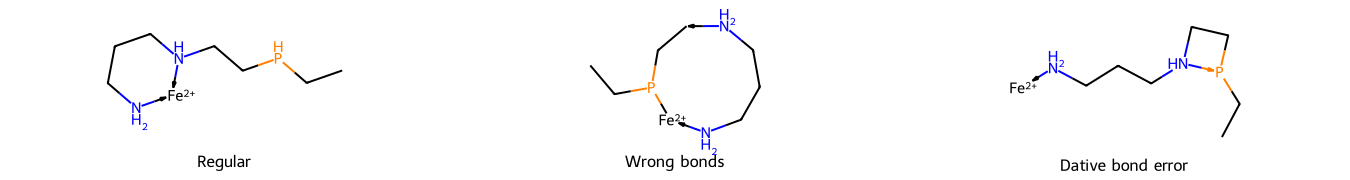

In [16]:
"""
    A simple example: [Fe+2]1<-N1CCCN->1CCP1CC
"""

smi1 = '[Fe+2]1<-NCCCN->1CCPCC'
smi2 = '[Fe+2]1<-NCCCN->CCP1CC'
smi3 = '[Fe+2]<-NCCCN->1CCP1CC'
mol1 = MolFromSmiles(smi1)
mol2 = MolFromSmiles(smi2)
mol3 = MolFromSmiles(smi3)
MolsToGridImage([mol1, mol2, mol3], subImgSize=(450,180),
                legends=['Regular', 'Wrong bonds', 'Dative bond error'])

###### **Section 2.2: exclude molecules having other chemical errors**
We obtain the molecules with only valence errors. Other common errors here are duplicated bonds for ring closure and aromatic atoms out of rings, both of which we cannot fix.

In [ ]:
valdict = defaultdict(list)
for idx, smi, vnum, vmols, vmdat in zip(vd_dict['ID'], vd_dict['LLM_SMI'], vd_dict['NumAttempts'],
                                        vd_dict['Mol_list'], vd_dict['Dative_list']):
    valence_mols = []
    valence_datv = []
    valence_errs = []
    for mol, datv in zip(vmols, vmdat):
        probs = DetectChemistryProblems(mol)
        valence_issue = False
        others = False
        if len(probs)>0:
            """
                Enumerate all chemical errors
                We use 'Explicit valence' substring to
                identify valence error messages
            """
            for prob in probs:
                if not 'Explicit valence' in prob.Message():
                    others = True
                    break
            if not others:
                valence_issue = True
        if not others:
            valence_mols.append(mol)
            valence_datv.append(datv)
            valence_errs.append(valence_issue)
    valdict['ID'].append(idx)
    valdict['LLM_SMI'].append(smi)
    valdict['NumAttempts'].append(vnum)
    valdict['NumValence'].append(len(valence_mols))
    valdict['Mol_list'].append(valence_mols)
    valdict['Dative_list'].append(valence_datv)
    valdict['Valence_list'].append(valence_errs)

In [6]:
valdf = pds.DataFrame({k: [n for n in v] for k, v in valdict.items() if not 'list' in k})
valdf.head(10)

,ID,LLM_SMI,NumAttempts,NumValence
0,0,CCC1(CC)CC(C)(C)N(CCCC([N+](C)(C)C)C2(C)[O-]->...,9,9
1,1,N#CC1C2(Cc3cccc4Oc5cccc6C=[SH]C77OCC4c4c(O)c5c...,150,30
2,2,C1=CC2=C3C=C(C4=N5->[Ni+2]67(<-N(=C8C=C(C9=N->...,25,24
3,3,CC1(C)O[O-]->[Cu+2]2(<-[O-]CCN->2(C)C)(<-N2=C(...,4,4
4,4,CCO[Si](C)(C)[C-]12->[Cr+3]34(<-[C-]#[O+])(<-[...,14,6
5,5,O=C1CN2CC(=O)[O-]->[Co+2]<-234(<-[O-]1)<-n1ccc...,5,5
6,6,CC1(C)C2CCC3N2->[Cu+2]2(<-N3=C1CCC3C(C)(C)C1CC...,100,100
7,7,CP1(C)CCP(C)(C)->[Ta+3]<-12(<-[C-]#[O+])(<-[N-...,8,8
8,8,CC(C)C1COC2C=C3c4ccccc4C4C=C5OCC(C(C)C)[N-]5->...,9,9
9,9,C=C([N-]1c2ccccc2C(C)N12Cc1ccccc1)->[Fe+2]<-12...,68,12


###### **Section 2.3: fix molecules with valence errors**
The valence error messages usually have the following format,  
> [21:37:24] Explicit valence for atom # \<Atom Index\> \<Atomic Symbol\>, \<Explicit Valence\>, is greater than permitted  
> e.g., [21:37:24] Explicit valence for atom # 1 N, 4, is greater than permitted
  
&emsp; The **\<Atom Index\>**, **\<Atomic Symbol\>**, and **\<Explicit Valence\>** are information we need to identify the `Atom`s having valence errors and select replacement elements to fix these errors. Text-based operations are enough to extract these information from valence error messages. Numerous other errors may occur when fixing valence errors, including encountering aromatic bonds, explicit valences higher than seven, and kekulization issues. We exclude molecules having these errors because it's time-consuming to fix each of them separately. In the final step of this workflow, we want to obtain canonical SMILES strings, while the RDKit kekulization algorithm may occasionally be incompatible with its canonicalization process. Thus, we try sanitizing the canonical SMILES strings and only take valid canonical strings.  
  
&emsp; The main output is `repdf` which lists representative TMCs for each of the unparsable strings in `unpardf`, while `outdf` lists all possible molecules (including many variations for each unparsable TMC).

In [ ]:
outdict = defaultdict(list)
repdict = defaultdict(list)
for idx, smi, vnum, valnum, vmols, vmdat, vmval in zip(valdict['ID'], valdict['LLM_SMI'],
                                                       valdict['NumAttempts'], valdict['NumValence'],
                                                       valdict['Mol_list'], valdict['Dative_list'],
                                                       valdict['Valence_list']):
    outsmis = []
    outdats = []
    outvals = []
    for mol, dat, val in zip(vmols, vmdat, vmval):
        probs = DetectChemistryProblems(mol)
        if len(probs)<1:

            ## Try canonical SMILES
            tmp_smi = Chem.MolToSmiles(mol, canonical=True)
            try:
                trial_mol = MolFromSmiles(tmp_smi)
            except:
                trial_mol = None
            if trial_mol!=None:
                if not tmp_smi in outsmis:
                    outsmis.append(tmp_smi)
                    outdats.append(dat)
                    outvals.append(val)
        else:
            ## Dump all other errors into the "issues"
            ## variable here. It's possible to identify
            ## each type of errors but it will then be
            ## unnecessary. 
            issues = False
            tmp_mol = Mol(mol)
            
            """
                Since there may be multiple valence errors,
                we enumerate all valence errors and fix each
                of them
            """
            for prob in probs:
                msg = prob.Message()
                msg_chars = msg.split()
                num = int(msg_chars[5])
                sym = msg_chars[6][:-1] ## to remove ','
                implied_val = int(msg_chars[7][:-1])
                
                ## Don't have replacement atoms for valences >= 7
                if implied_val>6:
                    issues = True
                    break
                
                try:
                    tmp, issues = AutoDischargeAtom(tmp_mol, num, atomSymbol=sym)
                except:
                    issues = True
                    break
                if issues:
                    break
                
                ## Update the current molecule after fixing
                ## each valence errors
                tmp_mol = Mol(tmp)
                
            if not issues:
                tmp_smi = Chem.MolToSmiles(tmp_mol, canonical=True)
                try:
                    trial_mol = MolFromSmiles(tmp_smi)
                except:
                    trial_mol = None
                if trial_mol!=None:
                    if not tmp_smi in outsmis:
                        outsmis.append(tmp_smi)
                        outdats.append(dat)
                        outvals.append(val)
    ## All possible TMCs retrieved from unparsable strings with unclosed rings
    for iidx, (outsmi, outdat, outval) in enumerate(zip(outsmis, outdats, outvals)):
        outdict['ID'].append(f'{idx}_{iidx}')
        outdict['LLM_SMI'].append(smi)
        outdict['Fixed_SMI'].append(outsmi)
        outdict['Dative'].append(outdat)
        outdict['Valence'].append(outval)
    
    ## One representative TMC for each unparsable string
    indices = [n for n in range(len(outsmis))]
    shuffle(indices)
    rep_idx = indices[0]
    repdict['ID'].append(f'{idx}_{rep_idx}')
    repdict['LLM_SMI'].append(smi)
    repdict['Fixed_SMI'].append(outsmis[rep_idx])
    repdict['Dative'].append(outdats[rep_idx])
    repdict['Valence'].append(outvals[rep_idx])
    repdict['NumAttempts'].append(vnum)
    repdict['NumValence'].append(valnum)
    repdict['NumOut'].append(len(outsmis))

In [7]:
outdf = pds.DataFrame(outdict)
outdf.head()

,ID,LLM_SMI,Fixed_SMI,Dative,Valence
0,0_0,CCC1(CC)CC(C)(C)N(CCCC([N+](C)(C)C)C2(C)[O-]->...,CCC1(CC)CC(C)(C)N2CCCC([N+](C)(C)C)C(C)[O-]->[...,True,True
1,0_1,CCC1(CC)CC(C)(C)N(CCCC([N+](C)(C)C)C2(C)[O-]->...,CCC1(CC)CC(C)(C)N2CCCC([N+](C)(C)C)C(C)[O-]->[...,True,True
2,0_2,CCC1(CC)CC(C)(C)N(CCCC([N+](C)(C)C)C2(C)[O-]->...,CCC1(CC)CC(C)(C)N2CCCC([N+](C)(C)C)C(C)[O-]->[...,True,True
3,0_3,CCC1(CC)CC(C)(C)N(CCCC([N+](C)(C)C)C2(C)[O-]->...,CCC1(CC)CC(C)(C)N2CCCC([N+](C)(C)C)C3(C)[O-]->...,True,True
4,0_4,CCC1(CC)CC(C)(C)N(CCCC([N+](C)(C)C)C2(C)[O-]->...,CCC1(CC)CC(C)(C)N2CCCC([N+](C)(C)C)C3(C)[O-]->...,True,True


In [8]:
"""
    ID:
        <Index of original string> _ <Index of variation>
"""
repdf = pds.DataFrame(repdict)
# repdf.to_csv('./retrieved_TMCs.csv')
repdf.head(10)

,ID,LLM_SMI,Fixed_SMI,Dative,Valence,NumAttempts,NumValence,NumOut
0,0_0,CCC1(CC)CC(C)(C)N(CCCC([N+](C)(C)C)C2(C)[O-]->...,CCC1(CC)CC(C)(C)N2CCCC([N+](C)(C)C)C(C)[O-]->[...,True,True,9,9,9
1,1_13,N#CC1C2(Cc3cccc4Oc5cccc6C=[SH]C77OCC4c4c(O)c5c...,CCCC12C3=C4CN5(->[Cr+3]678<-O=C4C4OCCc9c(cccc1...,True,True,150,30,15
2,2_12,C1=CC2=C3C=C(C4=N5->[Ni+2]67(<-N(=C8C=C(C9=N->...,C=CC1=C(C2=CC=C3c2ccccc2C=C[N-]3->[Ni+2]234<-N...,True,True,25,24,24
3,3_3,CC1(C)O[O-]->[Cu+2]2(<-[O-]CCN->2(C)C)(<-N2=C(...,CCCC1=N(->[Cu+2]23(<-[O-]CCN->2(C)C)<-[O-]OC(C...,True,True,4,4,4
4,4_5,CCO[Si](C)(C)[C-]12->[Cr+3]34(<-[C-]#[O+])(<-[...,CCO[Si](C)(C)[C-]12->[Cr+3]345(<-[C-]#[O+])(<-...,True,True,14,6,6
5,5_3,O=C1CN2CC(=O)[O-]->[Co+2]<-234(<-[O-]1)<-n1ccc...,CCC(=O)N1C(=O)c2ccc3ccc4cccn5->[Co+2]367(<-[O-...,True,True,5,5,5
6,6_53,CC1(C)C2CCC3N2->[Cu+2]2(<-N3=C1CCC3C(C)(C)C1CC...,CC1(C)C(CCC2C3CCC4N3C3=CCCC(C(CCC3)C2(C)C)C4(C...,True,True,100,100,100
7,7_1,CP1(C)CCP(C)(C)->[Ta+3]<-12(<-[C-]#[O+])(<-[N-...,CN1CCCCCC2CCCCCCC(=[N-]->[Ta+3]34(<-[C-]#[O+])...,True,True,8,8,8
8,8_7,CC(C)C1COC2C=C3c4ccccc4C4C=C5OCC(C(C)C)[N-]5->...,CC(C)C1COC2=N1->[Ni+2]13<-N=C(C=C4OCC(C(C)C)[N...,True,True,9,9,9
9,9_1,C=C([N-]1c2ccccc2C(C)N12Cc1ccccc1)->[Fe+2]<-12...,C=C(N1c2cccccC(C)C21Cc1ccccc1)->[Fe+2]12(<-N(C...,False,True,68,12,12


**Note**: the `NumOut` column corresponds to the `TotalNum` in `unpardf`. `Dative` and `Valence` indicate whether the original TMC-SMILES strings have dative bond errors or valence errors. Since we select the representative TMCs randomly, `Dative` and `Valence` in `repdf` may be different from those in `unpardf`.

###### **<u>Possible kekulization errors after changing atom types</u>**
Changing atom type is the basic operation in our algorithm to fix valence errors. Here we briefly demonstrate how this operation may change a valid molecule to a molecule with kekulization issues. This is one of the factors affecting the retrieving efficiency. Howeverm, kekulization issues after changing atom types are not too common overall, so it's still worthwhile to apply the valence algorithm and retrieve more molecules.

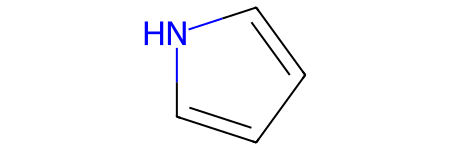

In [9]:
smi = 'c1c[nH]cc1'
mol = MolFromSmiles(smi)
mol

In [10]:
new = Mol(mol)
atom = new.GetAtomWithIdx(2)
atom.SetAtomicNum(6) ## Change the nitrogen to carbon
new_smi = MolToSmiles(new)
print(new_smi)
fin = MolFromSmiles(new_smi)

c1cccc1


[17:02:42] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4


#### Section 3: fixing atoms with valence errors
The algorithm is to fix the molecules having valence errors by changing the atom types to those having higher permitted valences. The replacement atoms are pre-defined (F, O, N, C, P, S) with permitted valences ranging from 1 to 6.
- the auto correction algorithm only fixes molecules to make them RDKit-parsable.  
  The structural properties remain the same, including ring structures, the number of macrocycles $N_{\mathrm{macrocycles}}$, the number of fused rings $N_{\mathrm{fused\ rings}}$, and the molecular spatial complexity
- chemical properties, especially the functional groups of original molecules will be changed so the output molecules may not be chemically valid, which need further screening
  
The main challenge is to correct charged atoms having valence issues. The explicit valence of central atom may be much higher than either the perimitted valence or total bonders because of its additional charges. In this case, one may choose replacement atom according to,  
&emsp; 1. the total bond order (neutral atoms)  
&emsp; 2. the explicit valence (total implied valence)  
Here, we prefer neutral atoms (the $1^{\mathrm{st}}$ approach), so the current algorithm will set the atom charge to zero first and then select replacement atoms with appropriate valence. **Note**: if using the $2^{\mathrm{nd}}$ approach (to select atoms having the same explicit valences), RDKit may assign unpaired electrons to the central atom in sanitization step.

In [10]:
## To make the legend font size larger
opts = Draw.MolDrawOptions()
opts.legendFraction = 0.15
opts.legendFontSize = 15

In [4]:
## molecules having valence errors
smi1 = 'CN(C)(C)C'
smi2 = 'C[O-](C)C'
smi3 = 'C[C-2](C)C'
for smi in [smi1, smi2, smi3]:
    check = MolFromSmiles(smi)

[21:37:24] Explicit valence for atom # 1 N, 4, is greater than permitted
[21:37:24] Explicit valence for atom # 1 O, 3, is greater than permitted
[21:37:24] Explicit valence for atom # 1 C, 3, is greater than permitted


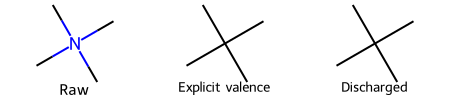

In [11]:
"""
    Regular valence errors
"""
mol = MolFromSmiles(smi1, sanitize=False)
bare_fix, aromatic_1 = AutoCorrectAtom(mol, atomId=1, atomSymbol='N', sanitize=True)
discharge_fix, aromatic_2 = AutoDischargeAtom(mol, atomId=1, atomSymbol='N', sanitize=True)
MolsToGridImage([mol, bare_fix, discharge_fix], subImgSize=(150,100),
                legends=['Raw', 'Explicit valence', 'Discharged'], drawOptions=opts)

In [12]:
"""
    Charged atoms with valence errors
"""
mol = MolFromSmiles(smi2, sanitize=False)
bare_fix, aromatic_1 = AutoCorrectAtom(mol, atomId=1, atomSymbol='O', sanitize=True)
discharge_fix, aromatic_2 = AutoDischargeAtom(mol, atomId=1, atomSymbol='O', sanitize=True)
print(MolToSmiles(bare_fix))

C[C](C)C


**Note**: (**attention**) if we just replace the [O-] with a carbon, though carbon has the same explicit valence (4) as suggested by the original string, RDKit will assign an unpaired electron to the carbon, making it '[C]'.

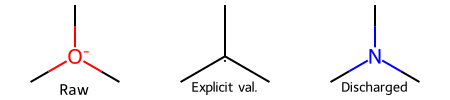

In [14]:
## Example 1
MolsToGridImage([mol, bare_fix, discharge_fix], subImgSize=(150,100),
                legends=['Raw', 'Explicit val.', 'Discharged'], drawOptions=opts)

In [15]:
## Example 2
mol = MolFromSmiles(smi3, sanitize=False)
bare_fix, aromatic_1 = AutoCorrectAtom(mol, atomId=1, atomSymbol='C', sanitize=True)
discharge_fix, aromatic_2 = AutoDischargeAtom(mol, atomId=1, atomSymbol='C', sanitize=True)

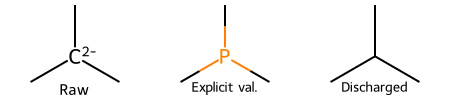

In [16]:
MolsToGridImage([mol, bare_fix, discharge_fix], subImgSize=(150,100),
                legends=['Raw', 'Explicit val.', 'Discharged'], drawOptions=opts)

    Copyright ©2025  The Regents of the University of California (Regents). All Rights Reserved. Permission to use, copy, modify, and distribute this software and its documentation for educational, research, and not-for-profit purposes, without fee and without a signed licensing agreement, is hereby granted, provided that the above copyright notice, this paragraph and the following paragraphs appear in all copies, modifications, and distributions. Contact The Office of Technology Licensing, UC Berkeley, 2150 Shattuck Avenue, Suite 408, Berkeley, CA 94704-1362, otl@berkeley.edu.

    Created by John Smith and Mary Doe, Department of Statistics, University of California, Berkeley.

    IN NO EVENT SHALL REGENTS BE LIABLE TO ANY PARTY FOR DIRECT, INDIRECT, SPECIAL, INCIDENTAL, OR CONSEQUENTIAL DAMAGES, INCLUDING LOST PROFITS, ARISING OUT OF THE USE OF THIS SOFTWARE AND ITS DOCUMENTATION, EVEN IF REGENTS HAS BEEN ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

    REGENTS SPECIFICALLY DISCLAIMS ANY WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE. THE SOFTWARE AND ACCOMPANYING DOCUMENTATION, IF ANY, PROVIDED HEREUNDER IS PROVIDED "AS IS". REGENTS HAS NO OBLIGATION TO PROVIDE MAINTENANCE, SUPPORT, UPDATES, ENHANCEMENTS, OR MODIFICATIONS